In [38]:
# https://www.kaggle.com/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store

# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import math
from matplotlib.pyplot import figure

In [2]:
# Read in data, sort by date

df = pd.read_csv('electronics.csv')
df = df.sort_values(by=['event_time'])

df

,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
53888,1970-01-01 00:33:40 UTC,2348532963655811776,2273948223972311310,2.268105e+18,NaN,NaN,2.29,NaN
42856,1970-01-01 00:33:40 UTC,2348531872843170520,1515966223509104250,2.268105e+18,electronics.audio.headphone,hyperx,113.40,NaN
42857,1970-01-01 00:33:40 UTC,2348531872843170520,1515966223509603707,2.268105e+18,appliances.kitchen.kettle,polaris,27.75,NaN
42858,1970-01-01 00:33:40 UTC,2348531872977388249,1515966223509267491,2.268105e+18,appliances.ironing_board,perilla,41.64,NaN
42859,1970-01-01 00:33:40 UTC,2348531873094828762,2273948227378086157,2.268105e+18,NaN,barkan,41.64,NaN
...,...,...,...,...,...,...,...,...
2633516,2020-11-21 10:10:01 UTC,2388440981134693942,1515966223526602848,2.268105e+18,electronics.smartphone,oppo,138.87,1.515916e+18
2633517,2020-11-21 10:10:13 UTC,2388440981134693943,1515966223509089282,2.268105e+18,electronics.smartphone,apple,418.96,1.515916e+18
2633518,2020-11-21 10:10:30 UTC,2388440981134693944,1515966223509089917,2.268105e+18,appliances.personal.scales,vitek,12.48,1.515916e+18
2633519,2020-11-21 10:10:30 UTC,2388440981134693944,2273948184839454837,2.268105e+18,NaN,moulinex,41.64,1.515916e+18


In [3]:
# Drop unnecessary columns

df1 = df.drop(columns=['order_id','category_id','user_id'])
df1

,event_time,product_id,category_code,brand,price
53888,1970-01-01 00:33:40 UTC,2273948223972311310,NaN,NaN,2.29
42856,1970-01-01 00:33:40 UTC,1515966223509104250,electronics.audio.headphone,hyperx,113.40
42857,1970-01-01 00:33:40 UTC,1515966223509603707,appliances.kitchen.kettle,polaris,27.75
42858,1970-01-01 00:33:40 UTC,1515966223509267491,appliances.ironing_board,perilla,41.64
42859,1970-01-01 00:33:40 UTC,2273948227378086157,NaN,barkan,41.64
...,...,...,...,...,...
2633516,2020-11-21 10:10:01 UTC,1515966223526602848,electronics.smartphone,oppo,138.87
2633517,2020-11-21 10:10:13 UTC,1515966223509089282,electronics.smartphone,apple,418.96
2633518,2020-11-21 10:10:30 UTC,1515966223509089917,appliances.personal.scales,vitek,12.48
2633519,2020-11-21 10:10:30 UTC,2273948184839454837,NaN,moulinex,41.64


In [4]:
# Check data types

df1.dtypes

event_time        object
product_id         int64
category_code     object
brand             object
price            float64
dtype: object

In [5]:
# Check for nulls

df1.isna().sum()

event_time            0
product_id            0
category_code    612202
brand            506005
price            431954
dtype: int64

In [6]:
# Drop nulls

df2 = df1.dropna()
df2

,event_time,product_id,category_code,brand,price
42856,1970-01-01 00:33:40 UTC,1515966223509104250,electronics.audio.headphone,hyperx,113.40
42857,1970-01-01 00:33:40 UTC,1515966223509603707,appliances.kitchen.kettle,polaris,27.75
42858,1970-01-01 00:33:40 UTC,1515966223509267491,appliances.ironing_board,perilla,41.64
42860,1970-01-01 00:33:40 UTC,1515966223509298672,electronics.audio.acoustic,sony,208.31
42864,1970-01-01 00:33:40 UTC,1515966223509130920,computers.components.hdd,transcend,99.51
...,...,...,...,...,...
2633515,2020-11-21 10:08:54 UTC,1515966223509088622,electronics.video.tv,lg,370.35
2633516,2020-11-21 10:10:01 UTC,1515966223526602848,electronics.smartphone,oppo,138.87
2633517,2020-11-21 10:10:13 UTC,1515966223509089282,electronics.smartphone,apple,418.96
2633518,2020-11-21 10:10:30 UTC,1515966223509089917,appliances.personal.scales,vitek,12.48


In [7]:
# Reformat dates and remove rows with date = 1970-01-01

df3 = df2.copy()
df3['event_time'] = df3['event_time'].map(lambda x: str(x)[:-13])
df3['event_time'] = pd.to_datetime(df3['event_time'])
df3 = df3[df3['event_time'] != '1970-01-01']

df3

,event_time,product_id,category_code,brand,price
65680,2020-01-05,1515966223509127455,appliances.personal.scales,scarlett,11.55
58798,2020-01-05,1515966223509089598,electronics.smartphone,huawei,138.63
60541,2020-01-05,1515966223509089470,computers.network.router,tp-link,27.75
60956,2020-01-05,2273948231689830404,appliances.kitchen.hood,jetair,150.44
68639,2020-01-05,1515966223509089483,electronics.smartphone,huawei,92.34
...,...,...,...,...,...
2633515,2020-11-21,1515966223509088622,electronics.video.tv,lg,370.35
2633516,2020-11-21,1515966223526602848,electronics.smartphone,oppo,138.87
2633517,2020-11-21,1515966223509089282,electronics.smartphone,apple,418.96
2633518,2020-11-21,1515966223509089917,appliances.personal.scales,vitek,12.48


In [25]:
# Count unqiue products sold on given day, add quantity column, and remove duplicates

df4 = df3.copy()

df4["quantity"] = 1
df4["quantity"] = df4.groupby(["event_time", "product_id", "category_code", "brand", "price"]).transform(sum)

df5 = df4.drop_duplicates(subset=["event_time", "product_id", "category_code", "brand", "price"], keep="first").reset_index(drop=True)

df5

,event_time,product_id,category_code,brand,price,quantity
0,2020-01-05,1515966223509127455,appliances.personal.scales,scarlett,11.55,20
1,2020-01-05,1515966223509089598,electronics.smartphone,huawei,138.63,37
2,2020-01-05,1515966223509089470,computers.network.router,tp-link,27.75,22
3,2020-01-05,2273948231689830404,appliances.kitchen.hood,jetair,150.44,1
4,2020-01-05,1515966223509089483,electronics.smartphone,huawei,92.34,16
...,...,...,...,...,...,...
521968,2020-11-21,1515966223509090132,computers.peripherals.printer,canon,299.98,1
521969,2020-11-21,1515966223519279912,electronics.video.tv,samsung,1736.09,1
521970,2020-11-21,1515966223509088622,electronics.video.tv,lg,370.35,1
521971,2020-11-21,1515966223509089282,electronics.smartphone,apple,418.96,1


In [9]:
# Replace dates with day/month/year columns

df6 = df5.copy()

df6['day'] = df6['event_time'].apply( lambda x: x.day )
df6['month'] = df6['event_time'].apply( lambda x: x.month )
df6['year'] = df6['event_time'].apply( lambda x: x.year )
df6 = df6.drop(columns=['event_time'])

cols = df6.columns.tolist()
cols = cols[-3:] + cols[:-3]
df6 = df6[cols]

df6

,day,month,year,product_id,category_code,brand,price,quantity
0,5,1,2020,1515966223509127455,appliances.personal.scales,scarlett,11.55,20
1,5,1,2020,1515966223509089598,electronics.smartphone,huawei,138.63,37
2,5,1,2020,1515966223509089470,computers.network.router,tp-link,27.75,22
3,5,1,2020,2273948231689830404,appliances.kitchen.hood,jetair,150.44,1
4,5,1,2020,1515966223509089483,electronics.smartphone,huawei,92.34,16
...,...,...,...,...,...,...,...,...
521968,21,11,2020,1515966223509090132,computers.peripherals.printer,canon,299.98,1
521969,21,11,2020,1515966223519279912,electronics.video.tv,samsung,1736.09,1
521970,21,11,2020,1515966223509088622,electronics.video.tv,lg,370.35,1
521971,21,11,2020,1515966223509089282,electronics.smartphone,apple,418.96,1


In [10]:
# Relabel product_id, category_code, and brand

df7 = df6.copy()

prods = df7.product_id.unique()

int_to_prod = {i:prod for i,prod in enumerate(prods)}
prod_to_int = {prod:i for i,prod in enumerate(prods)}

df7['product_id'] = df7['product_id'].apply( lambda x: prod_to_int[x] )

cats = df7.category_code.unique()

int_to_cat = {i:cat for i,cat in enumerate(cats)}
cat_to_int = {cat:i for i,cat in enumerate(cats)}

df7['category_code'] = df7['category_code'].apply( lambda x: cat_to_int[x] )

brands = df7.brand.unique()

int_to_brand = {i:brand for i,brand in enumerate(brands)}
brand_to_int = {brand:i for i,brand in enumerate(brands)}

df7['brand'] = df7['brand'].apply( lambda x: brand_to_int[x] )

df7

,day,month,year,product_id,category_code,brand,price,quantity
0,5,1,2020,0,0,0,11.55,20
1,5,1,2020,1,1,1,138.63,37
2,5,1,2020,2,2,2,27.75,22
3,5,1,2020,3,3,3,150.44,1
4,5,1,2020,4,1,1,92.34,16
...,...,...,...,...,...,...,...,...
521968,21,11,2020,2378,45,14,299.98,1
521969,21,11,2020,8896,25,5,1736.09,1
521970,21,11,2020,442,25,31,370.35,1
521971,21,11,2020,362,1,8,418.96,1


In [41]:
# a = df7.groupby('product_id',as_index = False)['quantity'].sum()
# a = a.sort_values(by='quantity',ascending=False)
# a

In [12]:
# Create train/test split

df = df7.copy()

train_frac = 0.8
train_len = int(len(df)*train_frac)

train_df = df[df.index < train_len]
y_train = train_df.pop('quantity')
X_train = train_df

test_df = df[df.index >= train_len]
y_test = test_df.pop('quantity')
X_test = test_df

len(df), len(X_train) + len(X_test)

(521973, 521973)

In [13]:
# Define categorical features

cat_columns = ["day", "month", "year", "product_id", "category_code", "brand"]
print("Names of categorical columns : ", cat_columns)

cat_idx = [df.columns.get_loc(col) for col in cat_columns]
print("Indices of categorical columns : ",cat_idx)

Names of categorical columns :  ['day', 'month', 'year', 'product_id', 'category_code', 'brand']
Indices of categorical columns :  [0, 1, 2, 3, 4, 5]


In [14]:
# Import the Pool class from catboost and use it for train/test split

from catboost import Pool


train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_idx
                 )

test_data = Pool(data=X_test,
                  label=y_test,
                  cat_features=cat_idx
                 )

In [42]:
# Creat catboost model and train it

cat_model = CatBoostRegressor()                              
cat_model.fit(train_data, eval_set=(X_test, y_test), plot=True)

In [34]:
# Generate model test predictions on particular product

prod_id = 27

x_pred = X_test[X_test['product_id'] == prod_id]
y_pred = cat_model.predict(x_pred)

C:\Users\16479\AppData\Local\Temp\ipykernel_20992\511657159.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['product_id'] = test['product_id'].apply( lambda x: prod_to_int[x] )


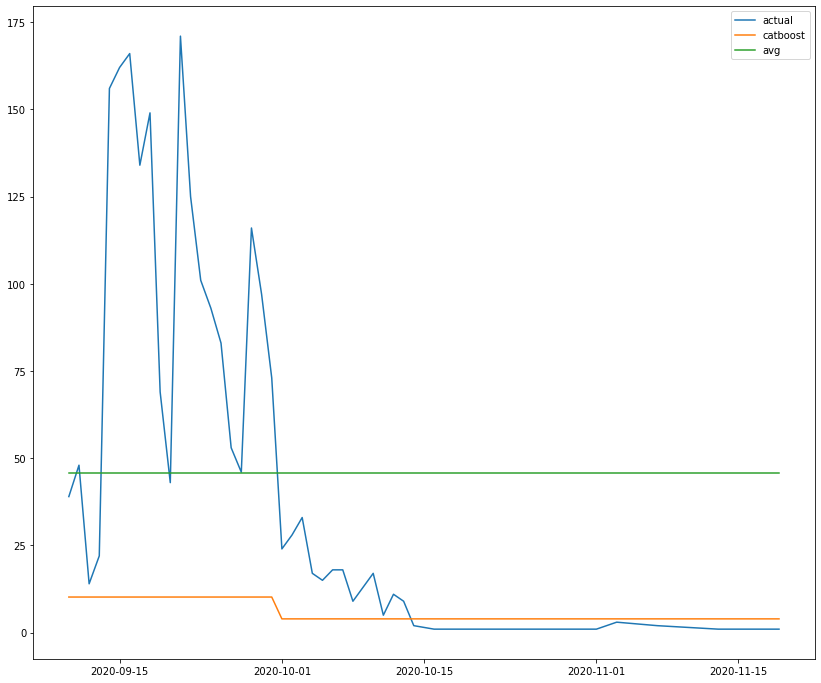

In [35]:
# Compare model test predictions with actual data

test = df5[df5.index >= train_len]

test['product_id'] = test['product_id'].apply( lambda x: prod_to_int[x] )
test = test[ test['product_id'] == prod_id ]

x1 = test['event_time']
y1 = test['quantity']

y1_avg = y1.mean()
y1_avg = np.ones(len(y1)) * y1_avg

figure(figsize=(14, 12))
plt.plot(x1,y1,label='actual')
plt.plot(x1,y_pred,label='catboost')
plt.plot(x1,y1_avg,label='avg')
plt.legend()

In [36]:
mean_squared_error(y1,y_pred)

4130.815084197025

In [37]:
mean_squared_error(y1,y1_avg)

2855.6875